In [12]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file),
                      target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})
 
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

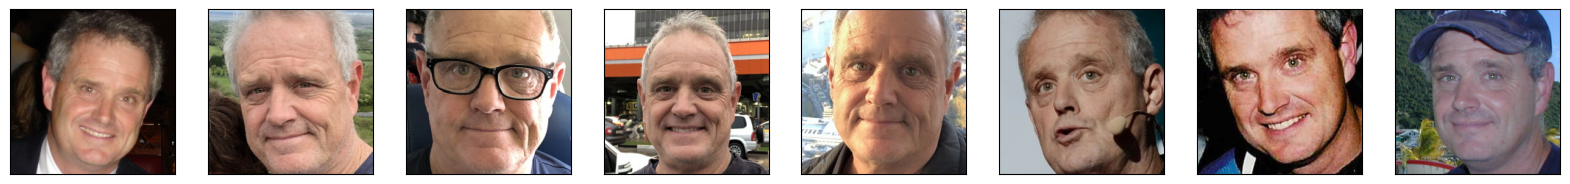

In [13]:
images, labels = load_images_from_path('Faces/Jeff', 0)
show_images(images)
    
x += images
y += labels

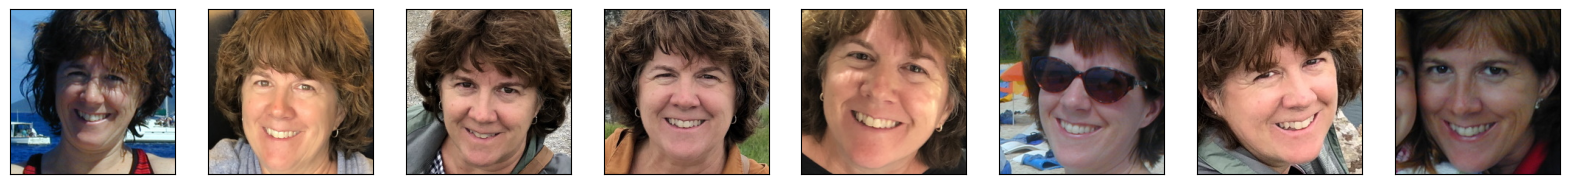

In [14]:
images, labels = load_images_from_path('Faces/Lori', 1)
show_images(images)
    
x += images
y += labels

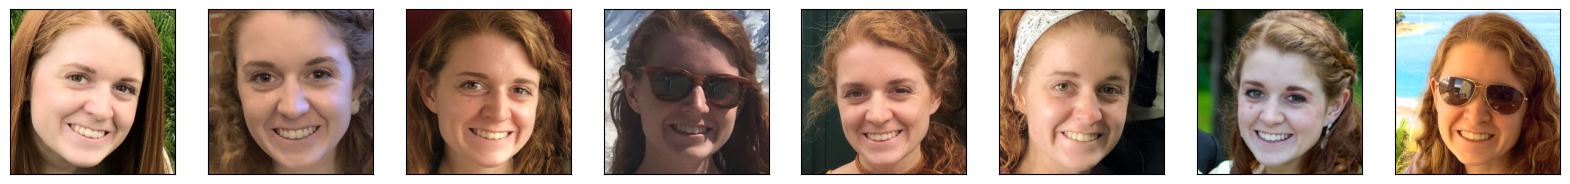

In [15]:
images, labels = load_images_from_path('Faces/Abby', 2)
show_images(images)
    
x += images
y += labels

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(
    faces, labels, train_size=0.5, stratify=labels,
    random_state=0)

In [ ]:
from tensorflow.keras.models import load_model

base_model = load_model('Data/vggface.h5')
base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 batch_size=2, epochs=10)

In [ ]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Sử dụng MTCNN để phát hiện khuôn mặt trong ảnh và mô hình được đào tạo để nhận dạng những khuôn mặt đó

In [23]:
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
    
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.9,
                show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]

    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']
        
        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
            # Optionally draw a box around the face
            if show_outline:
                rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
                ax.add_patch(rect)
            
            # Label the face
            index = int(np.argmax(predictions))
            text = f'{names[index]} ({confidence:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red',
                    ha='center', va='bottom', fontweight='bold',
                    bbox=dict(color='red'))

In [ ]:
labels = ['Jeff', 'Lori', 'Abby']
label_faces('Faces/Samples/Sample-1.jpg', model, labels)

In [ ]:
label_faces('Faces/Samples/Sample-2.jpg', model, labels)

In [ ]:
label_faces('Faces/Samples/Sample-3.jpg', model, labels)